In [1]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from src.preprocessing import make_dataset, recover_split
from src.utils import read_jsonl
import numpy as np
import seaborn as sns

c:\Users\pierr\.conda\envs\irony\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_NAME = "CreativeLang/EPIC_Irony"
df = make_dataset(pd.DataFrame(load_dataset(DATASET_NAME)['train']))

In [51]:
def get_golds_preds(split):
    golds = [item['gold'] for item in split]
    preds = [item['pred'] for item in split]
    return golds, preds

def evaluate_result(result):
    outputs = []
    for split in result:
        outputs.append(evaluate_split(split))
    return outputs

def evaluate_split(split):
    golds, preds = get_golds_preds(split)
    outputs = classification_report(golds, preds, output_dict=True)
    outputs['mcc'] = matthews_corrcoef(golds, preds)
    return outputs

def group_metric(metrics, k, kk=None):
    if kk==None:
        values = [m[k] for m in metrics]
    else:
        values = [m[k][kk] for m in metrics]
    return np.round(np.min(values), 4), np.round(np.mean(values), 4), np.round(np.max(values), 4), np.round(np.std(values), 4)

def compute_metric_stats(metrics):
    for k, v in metrics[0].items():
        if isinstance(v, dict):
            for kk, vv in v.items():
                print(k, kk, group_metric(metrics, k, kk))
        else:
            print(k, group_metric(metrics, k))

In [66]:
data = read_jsonl('results/clm_llama_nt.jsonl')
metrics = evaluate_result(data)
compute_metric_stats(metrics)

0 precision (0.7636, 0.7654, 0.7666, 0.001)
0 recall (0.9572, 0.9639, 0.9691, 0.0046)
0 f1-score (0.8511, 0.8532, 0.8553, 0.0015)
0 support (421.0, 421.0, 421.0, 0.0)
1 precision (0.1765, 0.229, 0.2609, 0.0293)
1 recall (0.0233, 0.0357, 0.0465, 0.0093)
1 f1-score (0.0411, 0.0615, 0.0789, 0.0148)
1 support (129.0, 129.0, 129.0, 0.0)
accuracy (0.7436, 0.7462, 0.7491, 0.0019)
macro avg precision (0.47, 0.4972, 0.5137, 0.0152)
macro avg recall (0.495, 0.4998, 0.5031, 0.0028)
macro avg f1-score (0.4472, 0.4574, 0.4656, 0.007)
macro avg support (550.0, 550.0, 550.0, 0.0)
weighted avg precision (0.6259, 0.6396, 0.648, 0.0077)
weighted avg recall (0.7436, 0.7462, 0.7491, 0.0019)
weighted avg f1-score (0.6628, 0.6675, 0.6709, 0.0029)
weighted avg support (550.0, 550.0, 550.0, 0.0)
mcc (-0.0245, -0.0017, 0.013, 0.013)


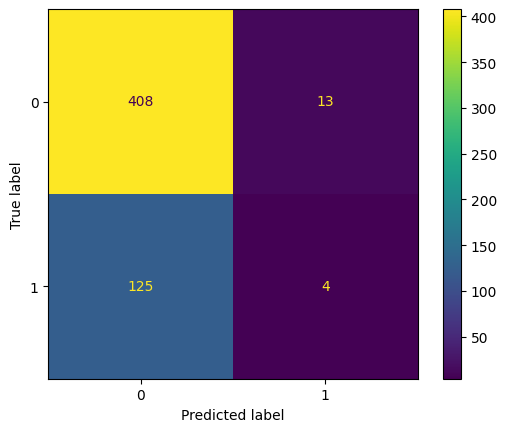

In [67]:
ConfusionMatrixDisplay(confusion_matrix(*get_golds_preds(data[4]))).plot()

In [ ]:
recover_split([item['id_original'] for item in read_jsonl('results/clm_llama_nt.jsonl')[1] if item['gold'] == 1 and item['pred'] == 1], df)

[{'source': 'twitter',
  'subreddit': None,
  'id_original': '1579732923032690688',
  'text': "@jeevanjyot20 @narendramodi Educate citizens instead of educating prime minister.  PARCIPATE &amp; bring change you wish to see. Don't seek Ministerial berth alone.",
  'parent_id_original': '1579706536410353665',
  'parent_text': "Where is BETI PARHAO BETI BACHAO @narendramodi ?\nGujarat ranking very poor  in girl child education\nOnly 10%  girls in Gujarat complete graduation\n20% per cent of girls don't reach class 10.\nGujarat  at the bottom in education of girls in the age group 10-14 years.",
  'Language_instance': 'en',
  'label': 1},
 {'source': 'twitter',
  'subreddit': None,
  'id_original': '1579751592810938370',
  'text': '@Lens_On_Eye I used to be that guy. \n\nBut ever since I got married, I don’t get those looks, but the stares 😂',
  'parent_id_original': '1579725620032196608',
  'parent_text': 'To all the girls who have eyes on only one guy are the real princess \U0001faf0🏻',


## Losses 

In [16]:
def plot_loss(states):
    best_split = np.argmax([state['best_metric'] for state in states])
    states[best_split]
    losses = []

    for i in range(0, len(states[best_split]['log_history'])-1, 2):
        losses.append((i / 2, states[best_split]['log_history'][i]['loss'], 'train'))
        losses.append((i / 2, states[best_split]['log_history'][i+1]['eval_loss'], 'val'))
    

    losses_df = pd.DataFrame(losses, columns=['epoch', 'loss', 'train_val'])

    sns.lineplot(
        data = losses_df,
        x = 'epoch',
        y = 'loss',
        hue = 'train_val'
    )
    

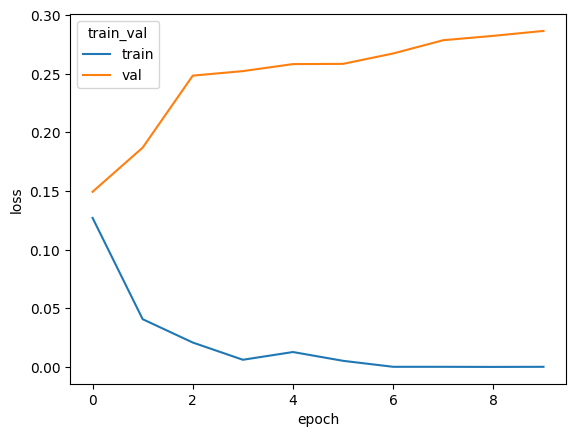

In [61]:
states = read_jsonl('results/roberta-irony-ft_loss.jsonl')
plot_loss(states)